In [1]:
import numpy as  np
from scipy import integrate
from scipy.special import lambertw
import CG as CG
from pycuba import Vegas
import ctypes

In [2]:
def der_rho_mono(psi): #derivada de rho respecto del potencial dos veces
    if psi==0:
        func=0
    else:
        aa=lambertw(-psi*np.exp(-psi),k=-1)
        func=-psi*(4*psi+(3+6*psi)*aa+6*aa**2)/((1+aa)**3*aa**2)
    if np.imag(func)!=0:
        print('hay un problema con la parte imaginaria de la funcion en la derivada')
        print(psi,func)
    else:
        func=np.real(func)
    return func
def integrando_fe(psi,ener): #integrando para f(e) la energía es la relativa, falta multiplicar por n_0
    drho=der_rho_mono(psi)
    cte=1/limite_energia**1.5
    func=drho*cte/(np.sqrt(8)*np.pi**2*np.sqrt(ener-psi))
    return func

In [3]:
def radio_plum(ms): #para plummer Erkal 1606.04946
    radio=1.62*np.sqrt(ms/1e8) #kpc
    return radio
def radio_her(ms): #para Hernquist Erkal 1606.04946
    radio=1.05*np.sqrt(ms/1e8) #kpc
    return radio

In [4]:
def nfw_MW(r,theta,phi): #da la funcion que debe entrar en el cálculo para el volumen del NSTAR 
    rcg2=cg_p[0]**2+cg_p[1]**2+cg_p[2]**2
    x=r*np.cos(phi)*np.sin(theta)
    y=r*np.sin(phi)*np.sin(theta)
    z=r*np.cos(theta)
    dd=rcg2+r**2-2*(x*cg_p[0]+y*cg_p[1]+z*cg_p[2])
    dd=np.sqrt(dd)/rmw
    rho=1/(dd*(1+dd)**2)
    func=rho*r**2*np.sin(theta)
    return func

def G1(r,theta,phi,v,thv,phiv,ms): # esta hace la integral en w y en psi
    vx=v*np.cos(phiv)*np.sin(thv)
    vy=v*np.sin(phiv)*np.sin(thv)
    vz=v*np.cos(thv)
    res_x=r*np.cos(phi)*np.sin(theta)-cg_p[0]
    res_y=r*np.sin(phi)*np.sin(theta)-cg_p[1]
    res_z=r*np.cos(theta)-cg_p[2]
    res=res_x**2+res_y**2+res_z**2
    alpha=(v**2+vsh**2+2*vsh*vx)/(2*limite_energia)
    y=-rmw*(1+lambertw(-alpha*np.exp(-alpha),k=-1)/alpha)
    if np.imag(y)==0:
        y=np.real(y)
        prod=vx*res_x+vy*res_y+vz*res_z
        radicando=prod**2+v**2*(y**2-res)
        if radicando>=0:
            w0p=(prod+np.sqrt(radicando))/v**2
            w0m=(prod-np.sqrt(radicando))/v**2
            #Hacer la integral
            if (w0p>0)&(w0m>0):
                f1=integrate.dblquad(integrando_nstar_w_psi,w0m,w0p,0,lambda w:rmw*np.log(1+np.sqrt(res+w**2*v**2-2*w*prod)/rmw)/np.sqrt(res+w**2*v**2-2*w*prod)-alpha,args=(r,theta,phi,v,thv,phiv,ms))
                func=f1[0]
            elif (w0p>0)&(w0m<0):
                f1=integrate.dblquad(integrando_nstar_w_psi,0,w0p,0,lambda w:rmw*np.log(1+np.sqrt(res+w**2*v**2-2*w*prod)/rmw)/np.sqrt(res+w**2*v**2-2*w*prod)-alpha,args=(r,theta,phi,v,thv,phiv,ms))
                func=f1[0]
            elif (w0p<0)&(w0m<0):
                func=0
        else:
            f1=integrate.dblquad(integrando_nstar_w_psi,0,np.infty,0,lambda w:rmw*np.log(1+np.sqrt(res+w**2*v**2-2*w*prod)/rmw)/np.sqrt(res+w**2*v**2-2*w*prod)-alpha,args=(r,theta,phi,v,thv,phiv,ms))
            func=f1[0]
    else:
        func=0
        print('Problemas con la parte compleja de la funci\'on de Lambert en el NSTAR')
    return func




def integrando_nstar_w_psi(psi,w,r,theta,phi,v,thv,phiv,ms): # integrando para las integrales de w y psi
    x=r*np.cos(phi)*np.sin(theta)
    y=r*np.sin(phi)*np.sin(theta)
    z=r*np.cos(theta)
    vx=v*np.cos(phiv)*np.sin(thv)
    vy=v*np.sin(phiv)*np.sin(thv)
    vz=v*np.cos(thv)
    dd=np.sqrt((x-cg_p[0]-vx*w)**2+(y-cg_p[1]-vy*w)**2+(z-cg_p[2]-vz*w)**2)
    ener=rmw*np.log(1+dd/rmw)/dd-(v**2+vsh**2+2*vsh*vx)/(2*limite_energia)
    if (ener>0)&(ener<1):
        f0_mw=integrando_fe(psi,ener)*np.heaviside(psi,0)*np.heaviside(1-psi,0)
    else:
        f0_mw=0
    rr=np.sqrt(r**2+w**2*v**2-2*w*(vx*x+vy*y+vz*z))
    if perturbador=='Plummer': # OJO que ya están multiplicados por el 4 pi G
        rs=radio_plum(ms)
        densidad=3*rs**2/(rs**2+rr**2)**2.5 
    elif perturbador=='NFW_expo':
        densidad= np.exp(-(rr/rc_NFW)**4)/(rr*(rr+rs_NFW)**2*k_NFW)
    elif perturbador=='Hernquist':
        rb_Her=radio_her(ms)
        densidad=2*rb_Her/(rr*(rb_Her+rr)**3*2)
    func=f0_mw*ms*densidad*w*gn
    return func

### Constantes y parámetros de la MW

In [5]:
vsh,cg_p=CG.CG_datos(9)
print('posicion de CG',cg_p)
print('velocidad del centro de masa',vsh)

salida de CG
velocidad del CM -288.0466074280818 km / s 120.56129658554741 km / s -35.1064378012592 km / s
módulo de velocidad 314.22656835523867 km / s
chequeo de velocidad con ángulos -288.0466074280818 120.56129658554741 -35.1064378012592
-288.0466074280818 120.56129658554742 -35.10643780125919
chequeo primer ángulos (<Quantity 314.22656836>, <Latitude -0.11195707 rad>, <Longitude 2.74519968 rad>)
314.22656835523867 -0.11195706644012555 2.7451996786521486
chequeo primer rotación 314.22656835523867 2.842170943040401e-14 0.0
posicion de CG [-8.948174238975904, 23.472574131574447, 43.50179588793219]
velocidad del centro de masa 314.22656835523867


In [6]:
# Constantes necesarias para el cálculo
msun=1.989e30 #kg
gn=6.672e-20*msun/3.0856e16 #km^2*kpc/s^2
# sacado de vasiliev 2024
mmw_NFW=1.29e12 # M_sun
rc=500 #kpc
rmw=16.5 #kpc
f_mw=lambda r:r*np.exp(-(r/rc)**4)/(rmw+r)**2
masa_mw=integrate.quad(f_mw,0,np.inf)[0] #adimensional
rho_mw=mmw_NFW/(masa_mw*4*np.pi*rmw**3) # M_sun/kpc**3
A_pot=4*np.pi*gn*rho_mw*rmw**3 # km**2*kpc/s**2
print('contante del potencial en km^2/s^2',A_pot)
limite_energia=4*np.pi*gn*rho_mw*rmw**2 # km^2/s^2
print('energía limite en km^2/s^2',limite_energia)
roi=100
#vol=integrate.tplquad(nfw_MW,0,2*np.pi,0,np.pi,0,roi,epsabs=1e-30) # km^3
#vol_densidad=vol[0]
vol_densidad=56631.40223054678
print('volumen a tener en cuenta para la densidad en kpc^3',vol_densidad)
#volumen a tener en cuenta para la densidad en kpc^3 56631.40223054678 (56631.40223054678, 195.14573290489082)

contante del potencial en km^2/s^2 2365828.5779461316
energía limite en km^2/s^2 143383.55017855344
volumen a tener en cuenta para la densidad en kpc^3 56631.40223054678


In [7]:
#elijo el modelo para el potencial del perturbador
perturbador='Plummer'#'NFW_expo' 'Hernquist'

In [8]:
# si elijo el NFW_expo para el perturbador
rc_NFW=roi*4 #kpc
rs_NFW=roi/3 #kpc
cte_NFW=lambda x: np.exp(-x**4)*x/(rs_NFW/rc_NFW+x)**2
k_NFW=integrate.quad(cte_NFW,0,np.infty)[0]
print(k_NFW)

1.528574510913949


In [9]:
G1(16,np.pi/3,np.pi/4,50,np.pi/24,np.pi/6,1e9)

1.4764666341493214e-13

In [10]:
def v0(theta_v, phi_v, epsilon_l, v_s):
    cos_phi_v = np.cos(phi_v)
    sin_theta_v = np.sin(theta_v)
    term1 = -cos_phi_v * sin_theta_v
    term2_sqrt_arg = (cos_phi_v * sin_theta_v)**2 - 1 + 2 * epsilon_l / v_s**2

    # check que el argumento de la raíz cuadrada sea no negativo
    if term2_sqrt_arg < 0:
        print("error")

    term2 = np.sqrt(term2_sqrt_arg)
    return v_s * (term1 + term2) 

# epsilon_l correspond to the limite_energia y v_s to vsh, se implemento esta formula a continuacion:
# vlim=vsh*(-np.cos(phiv)*np.sin(thv)+np.sqrt((np.cos(phiv)*np.sin(thv))**2-1+2*limite_energia/vsh**2))

In [11]:
def integrand(ndim, x, ncomp, f, userdata):
    # Desempaquetar variables de integración
    y = np.array([x[i] for i in range(ndim.contents.value)])
    jacobian = 1.0

    # Mapear y calcular el jacobiano para cada variable
    # r: de 0 a roi
    y_r = y[0]
    r = roi * y_r
    jacobian *= roi

    # theta: de 0 a pi
    y_theta = y[1]
    theta = np.pi * y_theta
    jacobian *= np.pi

    # phi: de 0 a 2*pi
    y_phi = y[2]
    phi = 2 * np.pi * y_phi
    jacobian *= 2 * np.pi

    # theta_v: de 0 a pi
    y_theta_v = y[3]
    theta_v = np.pi * y_theta_v
    jacobian *= np.pi

    # phi_v: de 0 a 2*pi
    y_phi_v = y[4]
    phi_v = 2 * np.pi * y_phi_v
    jacobian *= 2 * np.pi

    # Calcular v0 y verificar límites
    v_max = v0(theta_v, phi_v, limite_energia, vsh)
    if v_max <= 0:
        f[0] = 0.0
        return 0

    # v: de 0 a v0(theta_v, phi_v)
    y_v = y[5]
    v = v_max * y_v
    jacobian *= v_max

    # Calcular el elemento de volumen
    volume_element = (r**2) * np.sin(theta) * (v**2) * np.sin(theta_v)

    # Obtener M_s del userdata
    M_s = ctypes.cast(userdata, ctypes.POINTER(ctypes.py_object)).contents.value


    # Calcular el integrando
    integrand_value = volume_element * G1(r, theta, phi, v, theta_v, phi_v, M_s) * jacobian

    f[0] = integrand_value
    
    return 0

In [24]:
def compute_integral(M_s_value):
    from ctypes import c_double
    
    res = Vegas(
        integrand,
        ndim=6,
        epsrel=1e-2,  # Cambiar la tolerancia! 
        epsabs=1e-8,
        maxeval=100000,# maximo numero de integraciones 
        verbose=0,     # regula la verbosidad
        seed=0,
        userdata=ctypes.cast(ctypes.pointer(ctypes.py_object(M_s_value)), ctypes.c_void_p)
    )

    integral_value = res['results'][0]['integral']
    estimated_error = res['results'][0]['error']

    return M_s_value, integral_value, estimated_error


In [25]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_compute(M_s_values, max_workers=8):
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit tasks to the executor
        future_to_Ms = {executor.submit(compute_integral, M_s): M_s for M_s in M_s_values}

        # Collect results as they complete
        for future in as_completed(future_to_Ms):
            M_s = future_to_Ms[future]
            try:
                M_s_value, integral, error = future.result()
                results.append((M_s_value, integral, error))
                print(np.log10(M_s))
            except Exception as exc:
                print(f"M_s = {M_s:.2e} generated an exception: {exc}")

    # Sort results by M_s (if needed)
    results.sort(key=lambda x: x[0])

    return results


mass_resolution = 6
if __name__ == '__main__':
    # Define the range of M_s values (logarithmic scale)
    log_M_s_values = np.linspace(8, 13, num=mass_resolution)  # Ajustar 'num' a la resolucion en masa
    M_s_values = 10 ** log_M_s_values

    # computo en cada core
    results = parallel_compute(M_s_values)

    # resultado final
    for M_s_value, integral, error in results:
        print(np.log10(M_s_value), integral, error) 
        pass  

#for M_s in M_s_values:
#    print(np.log10(M_s))
#    integral, error = compute_integral(M_s)
#    results.append((M_s, integral, error))
#print(f"M_s = {M_s:.2e}, Integral = {integral:.6e}, Error = {error:.6e}")

13.0
12.0
11.0
10.0
9.0
8.0
8.0 0.6601657104847849 0.0795419277267794
9.0 26.200132845024694 1.4420846554358182
10.0 615.0844984722643 8.513285188744009
11.0 3971.9465382149046 40.27092931614606
12.0 5723.403464838611 56.078951398346035
13.0 2890.6177917011187 27.262639268852908


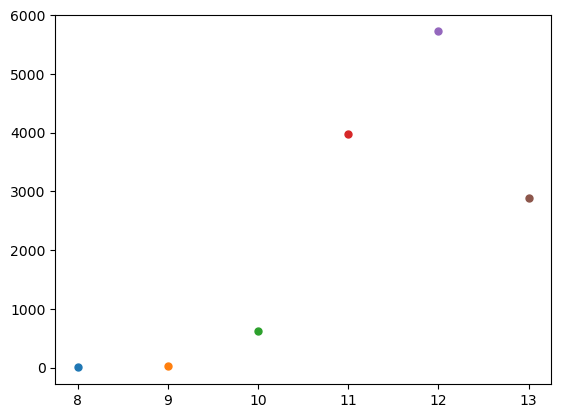

In [47]:
import matplotlib.pyplot as plt
for M_s_value, integral, error in results:
    plt.plot(np.log10(M_s_value), integral,  marker = 'o', markersize = 5)
plt.show()

In [28]:
results

[(100000000.0, 0.6601657104847849, 0.0795419277267794),
 (1000000000.0, 26.200132845024694, 1.4420846554358182),
 (10000000000.0, 615.0844984722643, 8.513285188744009),
 (100000000000.0, 3971.9465382149046, 40.27092931614606),
 (1000000000000.0, 5723.403464838611, 56.078951398346035),
 (10000000000000.0, 2890.6177917011187, 27.262639268852908)]

In [ ]:
?Vegas

La integral que hay que hacer es
$$ \int_0^{roi} \int_0^\pi \int_0^{2\pi} \int_0^\pi \int_0^{2\pi}\int_0^{v_0(\theta_v,\phi_v)} r^2 \sin(\theta) v^2 \sin (\theta_v) 
G1(r,\theta,\phi,v,\theta_v,\phi_v,M_s) {\rm d}v \, {\rm d}\phi_v \, {\rm d}\theta_v \, {\rm d}\phi \, {\rm d}\theta \, {\rm d}r $$
en función de la masa del subhalo que es $M_s$. 

Necesitaría esta integral para rangos de masa de $10^8 \leq M_s \leq 10^{13}$ en unidades de masas solares (en el código ms ya está en masas solares). Tal vez te convenga pasar a masas logartimicas, es decir hacer un grillado en $\log_{10} M_s$ y hacer un barrido entre $8 \leq  \log_{10} M_s  \leq 13$ por cuestiones numéricas.

El límite para la velocidad es
$$v_0(\theta_v,\phi_v)=v_s\left(-\cos(\phi_v) \sin(\theta_v)+\sqrt{(\cos(\phi_v) \sin(\theta_v))^2-1+2 \frac{\epsilon_l}{v_s^2}}\right)$$

Traducción entre variables de la integral anterior y del código:
* $r$ -> r
* $\theta$ -> theta
* $\phi$ -> phi
* $v$ -> v
* $\theta_v$ -> thv
* $\phi_v$ -> phiv
* $M_s$ -> ms
* $v_0(\theta_v,\phi_v)$ -> vlim
* $v_s$ -> vsh
* $\epsilon_l$ -> limite_energia

In [ ]:
# The code that follow is for testing porpouses.

In [ ]:
import numpy as np
from pycuba import Vegas
from ctypes import c_double

def integrand(ndim, x, ncomp, f, userdata):
    # Print statement to confirm the function is called
    #print("Integrand called")

    # Number of dimensions
    n = ndim.contents.value

    # Integration variables
    y = x[0:n]

    # For demonstration, compute a simple function
    # f(x) = exp(-sum(y))
    integrand_value = np.exp(-np.sum(y))

    # Store the result
    f[0] = integrand_value

    return 0  # Indicate success

# Integration parameters
ndim = 6
ncomp = 1

# Perform the integration
res = Vegas(
    integrand,
    ndim=ndim,
    ncomp=ncomp,
    epsrel=1e-3
)

print(f"Result: {res['results'][0]['integral']}")
print(f"Estimated Error: {res['results'][0]['error']}")
#print(res)

In [ ]:
import numpy as np
from pycuba import Vegas
from ctypes import c_double
import logging
import multiprocessing

# Configure logging at the module level
logging.basicConfig(
    level=logging.INFO,
    format='%(process)d-%(levelname)s-%(message)s'
)


# Constants
roi = 1.0
epsilon_l = 1.0
v_s = 1.0
M_s_value = 10**10.

def v0(theta_v, phi_v):
    cos_phi_v = np.cos(phi_v)
    sin_theta_v = np.sin(theta_v)
    term1 = -cos_phi_v * sin_theta_v
    term2_sqrt_arg = (cos_phi_v * sin_theta_v)**2 - 1 + 2 * epsilon_l / v_s**2
    term2_sqrt_arg = max(term2_sqrt_arg, 0.0)
    term2 = np.sqrt(term2_sqrt_arg)
    return v_s * (term1 + term2)

def G1(r, theta, phi, v, theta_v, phi_v, M_s):
    return np.exp(-r / M_s) * np.sin(v)

def integrand(ndim, x, ncomp, f, userdata):
    try:
        logging.info("Integrand called")
        # Your integrand computation
        f[0] = 1.0  # Example value
        return 0
    except Exception as e:
        logging.error(f"Exception in integrand: {e}")
        # Optionally, print the exception to the console
        print(f"Exception in integrand: {e}")
        return -1  # Indicate failure



if __name__ == '__main__':
    M_s_c = c_double(M_s_value)

    res = Vegas(
        integrand,
        ndim=6,
        ncomp=1,
        epsrel=1e-3,
        verbose=2
    )
    print(f"Result:", res)
    

In [ ]:
import numpy as np
from pycuba import Vegas
import ctypes
import time

# Constants
roi = 1.0
epsilon_l = 1.0
v_s = 1.0
M_s_value = 1e10  # Mass value

def v0(theta_v, phi_v):
    cos_phi_v = np.cos(phi_v)
    sin_theta_v = np.sin(theta_v)
    term1 = -cos_phi_v * sin_theta_v
    term2_sqrt_arg = (cos_phi_v * sin_theta_v)**2 - 1 + 2 * epsilon_l / v_s**2
    term2_sqrt_arg = max(term2_sqrt_arg, 0.0)
    term2 = np.sqrt(term2_sqrt_arg)
    return v_s * (term1 + term2)

def G1(r, theta, phi, v, theta_v, phi_v, M_s):
    return np.exp(-r / M_s) * np.sin(v)

def integrand(ndim, x, ncomp, f, userdata):
    try:
        # Retrieve M_s_value from userdata
        M_s = ctypes.cast(userdata, ctypes.POINTER(ctypes.py_object)).contents.value

        # Proceed with your integrand computations using M_s
        # For demonstration, we'll return a simple function involving M_s
        f[0] = np.exp(-M_s * x[0])  # Example computation
        return 0
    except Exception as e:
        print(f"Exception in integrand: {e}", flush=True)
        return -1

def main():
    start_time = time.time()

    # Wrap M_s_value and pass as userdata
    userdata = ctypes.cast(ctypes.pointer(ctypes.py_object(M_s_value)), ctypes.c_void_p)

    res = Vegas(
        integrand,
        ndim=6,
        ncomp=1,
        epsrel=1e-2,  # Loosen tolerances for testing
        epsabs=1e-6,
        verbose=2,
        seed=0,
        userdata=userdata  # Pass the wrapped userdata
    )

    elapsed_time = time.time() - start_time
    print(f"Result: {res['result'][0]}, Estimated Error: {res['error'][0]}")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

if __name__ == '__main__':
    main()
